In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import re
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Set up

In [2]:
# Set up paths
PROJECT_DIR = os.environ.get('PROJECT_DIR', os.path.expanduser('~/projects/metagenomics'))
TAXONOMY_DIR = os.environ.get('TAXONOMY_DIR', os.path.join(PROJECT_DIR, 'taxonomic_profiles'))
RESULTS_DIR = os.environ.get('RESULTS_DIR', os.path.join(PROJECT_DIR, 'results'))
METADATA_PATH = os.environ.get('METADATA_PATH', os.path.join(PROJECT_DIR, 'metadata_metagenomics.csv'))

# Ensure results directory exists
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

# Create output directory for plots
plots_dir = os.path.join(RESULTS_DIR, 'complete_metagenomics_plots')
Path(plots_dir).mkdir(parents=True, exist_ok=True)

In [3]:
# Convert mm to inches
def mm_to_inches(mm):
    return mm / 25.4

# Set maximum plot dimensions in inches
MAX_WIDTH_INCHES = mm_to_inches(80)
MAX_HEIGHT_INCHES = mm_to_inches(120)



In [4]:
# Set font sizes
SMALL_FONT = 6
MEDIUM_FONT = 8
LARGE_FONT = 10

# Set global font sizes for matplotlib
plt.rcParams.update({
    'font.size': SMALL_FONT,
    'axes.titlesize': MEDIUM_FONT,
    'axes.labelsize': SMALL_FONT,
    'xtick.labelsize': SMALL_FONT,
    'ytick.labelsize': SMALL_FONT,
    'legend.fontsize': SMALL_FONT,
    'figure.titlesize': MEDIUM_FONT
})


In [5]:
# Find all available profile files
profile_files = glob.glob(os.path.join(TAXONOMY_DIR, '*', '*_profile.txt'))
print(f"Found {len(profile_files)} profile files")

# Extract actual sample names from profile files
profile_sample_names = [os.path.basename(f).replace('_profile.txt', '') for f in profile_files]

# Load metadata
metadata = pd.read_csv(METADATA_PATH)
print(f"Loaded metadata with {len(metadata)} samples")

Found 22 profile files
Loaded metadata with 20 samples


In [6]:
# Create a mapping between metadata sample IDs and profile file sample names
sample_id_mapping = {}

# First, try direct matching
for profile_sample in profile_sample_names:
    if profile_sample in metadata['sample_id'].values:
        sample_id_mapping[profile_sample] = profile_sample
        continue
    
    # Try matching by removing the _S## suffix
    base_name = re.sub(r'_S\d+$', '', profile_sample)
    if base_name in metadata['sample_id'].values:
        sample_id_mapping[profile_sample] = base_name
        continue
    
    # Try matching in the other direction - metadata ID might have an extension
    for meta_id in metadata['sample_id'].values:
        if meta_id in profile_sample or profile_sample.startswith(meta_id):
            sample_id_mapping[profile_sample] = meta_id
            break

# Create a mapping of metadata sample IDs to patient and pre/post status
meta_info = {}
for _, row in metadata.iterrows():
    sample_id = row['sample_id']
    meta_info[sample_id] = {
        'patient': row['patient'],
        'post_pre': row['post_pre_status'],
        'type': 'Healthy' if row['patient'] == 'healthy' or str(row['patient']).startswith('H') else 'Treated'
    }

# Group samples by patient and pre/post status
patient_samples = {}
healthy_samples = []
treated_pre_samples = []
treated_post_samples = []

for profile_name, meta_id in sample_id_mapping.items():
    if meta_id not in meta_info:
        continue
    
    info = meta_info[meta_id]
    patient = info['patient']
    status = info['post_pre']
    
    if info['type'] == 'Treated':
        if patient not in patient_samples:
            patient_samples[patient] = {'pre': [], 'post': []}
        
        if status == 'pre':
            patient_samples[patient]['pre'].append(profile_name)
            treated_pre_samples.append(profile_name)
        elif status == 'post':
            patient_samples[patient]['post'].append(profile_name)
            treated_post_samples.append(profile_name)
    elif info['type'] == 'Healthy':
        healthy_samples.append(profile_name)

# Count patients with both pre and post samples
patients_with_both = [p for p, s in patient_samples.items() if s['pre'] and s['post']]
print(f"Found {len(patients_with_both)} patients with both pre and post samples: {patients_with_both}")

if not patients_with_both:
    sys.exit("No patients with both pre and post samples found. Cannot generate plots.")

# Load and process all profile files
print("Processing taxonomic data...")
all_data = {}
all_clades = set()

for profile_file in profile_files:
    sample_name = os.path.basename(profile_file).replace('_profile.txt', '')
    
    try:
        # Read profile file
        df = pd.read_csv(profile_file, sep='\t', skiprows=6, usecols=[0, 2], header=None)
        df.columns = ['clade_name', 'abundance']
        
        # Convert abundance to numeric
        df['abundance'] = pd.to_numeric(df['abundance'], errors='coerce')
        
        # Save to dictionary
        all_data[sample_name] = dict(zip(df['clade_name'], df['abundance']))
        all_clades.update(df['clade_name'])
    except Exception as e:
        print(f"Error loading file {profile_file}: {e}")

print(f"Loaded data for {len(all_data)} samples with {len(all_clades)} unique clades")

Found 8 patients with both pre and post samples: ['53', '10', '12', '46', '14', '45', '27', '43']
Processing taxonomic data...
Loaded data for 22 samples with 1973 unique clades


In [7]:
# Convert to DataFrame
clade_df = pd.DataFrame(index=list(all_clades))

# Fill in abundance values for each sample
for sample, data in all_data.items():
    clade_df[sample] = clade_df.index.map(lambda x: data.get(x, 0))

# Extract taxonomic levels
clade_df['tax_level'] = clade_df.index.map(lambda x: len(x.split('|')))
clade_df['tax_name'] = clade_df.index.map(lambda x: x.split('|')[-1].replace('s__', '').replace('g__', '').replace('p__', '').replace('_', ' '))

# Filter for species, genus, and phylum data
species_data = clade_df[clade_df.index.str.contains('s__') & ~clade_df.index.str.contains('t__')]
genus_data = clade_df[clade_df.index.str.contains('g__') & ~clade_df.index.str.contains('s__')]
phylum_data = clade_df[clade_df.index.str.contains('p__') & ~clade_df.index.str.contains('c__')]

print(f"Extracted {len(species_data)} species, {len(genus_data)} genera, and {len(phylum_data)} phyla")

Extracted 581 species, 349 genera, and 13 phyla


In [8]:
# Create paired sample lists for visualisation
paired_samples = []
paired_labels = []

for patient in patients_with_both:
    # Use the first pre and post sample for each patient
    pre_sample = patient_samples[patient]['pre'][0] if patient_samples[patient]['pre'] else None
    post_sample = patient_samples[patient]['post'][0] if patient_samples[patient]['post'] else None
    
    if pre_sample and post_sample:
        paired_samples.append(pre_sample)
        paired_samples.append(post_sample)
        paired_labels.append(f"{patient} (Pre)")
        paired_labels.append(f"{patient} (Post)")

print(f"Creating visualisations for {len(paired_samples)} paired samples")

Creating visualisations for 16 paired samples


### Species and genus heatmaps

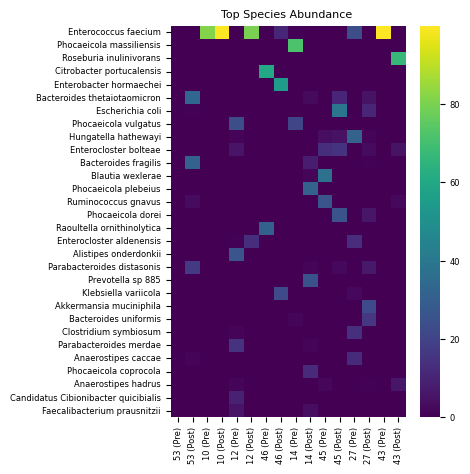

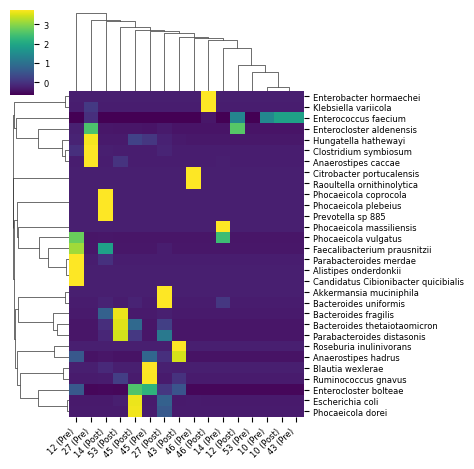

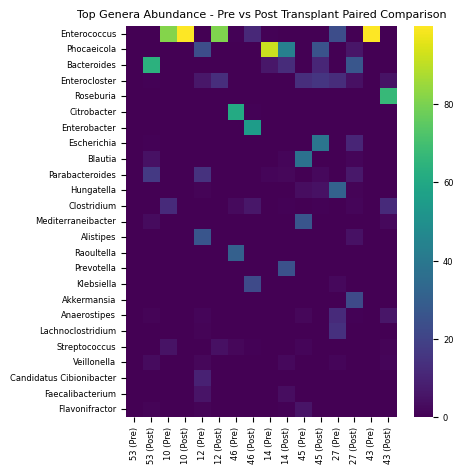

In [16]:
# Species heatmap pre vs post
if len(species_data) > 0 and paired_samples:
    # Get sample columns
    sample_cols = [col for col in species_data.columns if col in paired_samples]
    if not sample_cols:
        print("Warning: No sample columns match paired samples")
    else:
        # Get abundance sums
        species_sum = species_data[sample_cols].sum(axis=1)
        
        # Get top species
        top_species_idx = species_sum.nlargest(30).index
        top_species = species_data.loc[top_species_idx]
        
        # Create heatmap data
        heatmap_data = top_species[sample_cols]
        
        # Create heatmap
        plt.figure(figsize=(MAX_WIDTH_INCHES * 1.5, MAX_HEIGHT_INCHES * 1))
        g = sns.heatmap(heatmap_data, cmap='viridis', 
                      xticklabels=paired_labels, yticklabels=top_species['tax_name'])
        plt.title('Top Species Abundance ')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'species_pre_post_heatmap.jpeg'), dpi=300)
        plt.show()
        
        # Try creating a clustermap
        try:
            g = sns.clustermap(heatmap_data, cmap='viridis', z_score=0, 
                              xticklabels=paired_labels, yticklabels=top_species['tax_name'],
                              figsize=(MAX_WIDTH_INCHES * 1.5, MAX_HEIGHT_INCHES * 1))
            # Rotate x-axis labels for better readability
            plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
            plt.savefig(os.path.join(plots_dir, 'species_pre_post_clustermap.png'), dpi=300)
            plt.show()
        except Exception as e:
            print(f"Warning: Could not create species clustermap: {e}")

# Genus heatmap pre vs post
if len(genus_data) > 0 and paired_samples:
    # Get sample columns
    sample_cols = [col for col in genus_data.columns if col in paired_samples]
    if not sample_cols:
        print("Warning: No sample columns match paired samples for genus data")
    else:
        # Get abundance sums
        genus_sum = genus_data[sample_cols].sum(axis=1)
        
        # Get top genera
        top_genus_idx = genus_sum.nlargest(25).index
        top_genus = genus_data.loc[top_genus_idx]
        
        # Create heatmap data
        heatmap_data = top_genus[sample_cols]
        
        # Create heatmap
        plt.figure(figsize=(MAX_WIDTH_INCHES * 1.5, MAX_HEIGHT_INCHES * 1))
        g = sns.heatmap(heatmap_data, cmap='viridis', 
                      xticklabels=paired_labels, yticklabels=top_genus['tax_name'])
        plt.title('Top Genera Abundance - Pre vs Post Transplant Paired Comparison')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'genus_pre_post_heatmap.jpeg'), dpi=300)
        plt.show()

### Healthy vs treated plots

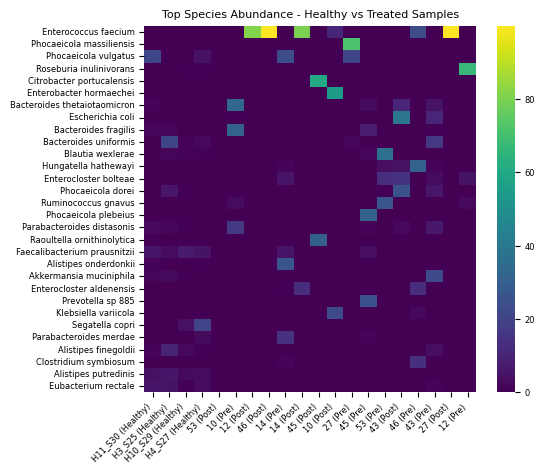

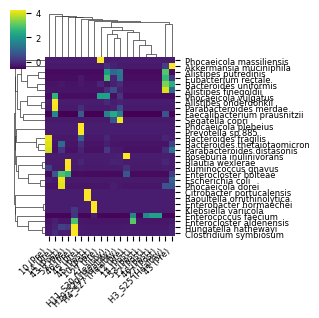

In [21]:
# Species heatmap: Healthy vs Treated (all)
if len(species_data) > 0 and healthy_samples and (treated_pre_samples or treated_post_samples):
    # Get all treated samples
    all_treated_samples = treated_pre_samples + treated_post_samples
    
    # Get sample columns
    healthy_cols = [col for col in species_data.columns if col in healthy_samples]
    treated_cols = [col for col in species_data.columns if col in all_treated_samples]
    sample_cols = healthy_cols + treated_cols
    
    if not sample_cols:
        print("Warning: No sample columns match healthy or treated samples")
    else:
        # Get abundance sums
        species_sum = species_data[sample_cols].sum(axis=1)
        
        # Get top species
        top_species_idx = species_sum.nlargest(30).index
        top_species = species_data.loc[top_species_idx]
        
        # Create heatmap data
        heatmap_data = top_species[sample_cols]
        
        # Create labels
        sample_labels = []
        for col in sample_cols:
            if col in healthy_samples:
                sample_labels.append(f"{col} (Healthy)")
            else:
                # Get patient and pre/post status
                for patient, samples in patient_samples.items():
                    if col in samples['pre']:
                        sample_labels.append(f"{patient} (Pre)")
                        break
                    elif col in samples['post']:
                        sample_labels.append(f"{patient} (Post)")
                        break
                else:
                    sample_labels.append(col)  # Fallback if not found
        
        # Create heatmap
        plt.figure(figsize=(MAX_WIDTH_INCHES * 1.8, MAX_HEIGHT_INCHES * 1))
        g = sns.heatmap(heatmap_data, cmap='viridis', 
                      xticklabels=sample_labels, yticklabels=top_species['tax_name'])
        plt.title('Top Species Abundance - Healthy vs Treated Samples')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'species_healthy_vs_treated_heatmap.jpeg'), dpi=300)
        plt.show()
        
        # Try creating a clustermap
        try:
            g = sns.clustermap(heatmap_data, cmap='viridis', z_score=0, 
                              xticklabels=sample_labels, yticklabels=top_species['tax_name'],
                              figsize=(MAX_WIDTH_INCHES, MAX_HEIGHT_INCHES * 0.7))
            # Rotate x-axis labels for better readability
            plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
            plt.savefig(os.path.join(plots_dir, 'species_healthy_vs_treated_clustermap.png'), dpi=300)
            plt.show()
        except Exception as e:
            print(f"Warning: Could not create species clustermap: {e}")



<Figure size 251.969x377.953 with 0 Axes>

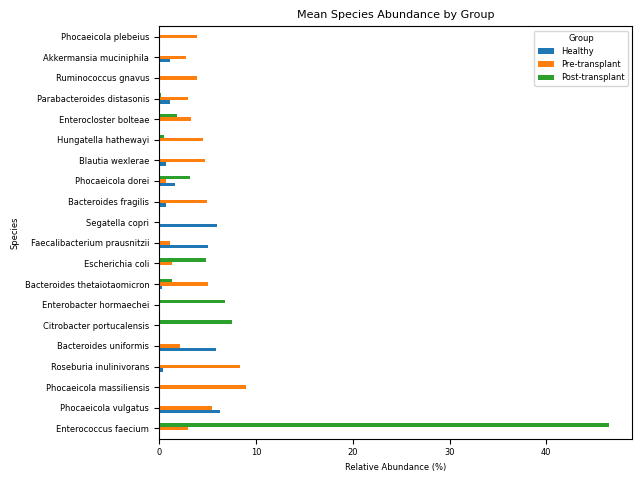

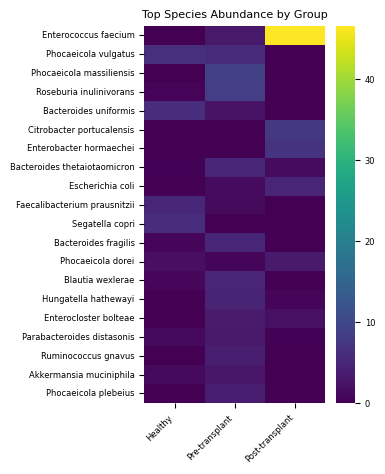

In [30]:
# Species composition by group: Healthy vs Pre vs Post
if len(species_data) > 0 and healthy_samples and treated_pre_samples and treated_post_samples:
    # Calculate mean abundances for each group
    species_means = pd.DataFrame(index=species_data.index)
    
    # Healthy group
    healthy_cols = [col for col in species_data.columns if col in healthy_samples]
    if healthy_cols:
        species_means['Healthy'] = species_data[healthy_cols].mean(axis=1)
    
    # Pre-transplant group
    pre_cols = [col for col in species_data.columns if col in treated_pre_samples]
    if pre_cols:
        species_means['Pre-transplant'] = species_data[pre_cols].mean(axis=1)
    
    # Post-transplant group
    post_cols = [col for col in species_data.columns if col in treated_post_samples]
    if post_cols:
        species_means['Post-transplant'] = species_data[post_cols].mean(axis=1)
    
    # Get top species
    species_means['Total'] = species_means.sum(axis=1)
    top_species_idx = species_means.nlargest(20, 'Total').index
    top_species_means = species_means.loc[top_species_idx, ['Healthy', 'Pre-transplant', 'Post-transplant']]
    
    # Create species labels
    species_labels = species_data.loc[top_species_idx, 'tax_name'].tolist()
    
    # Create bar plot
    plt.figure(figsize=(MAX_WIDTH_INCHES * 0.8, MAX_HEIGHT_INCHES * 0.8))
    
    # Transpose for horizontal bars
    plot_data = top_species_means.copy()
    plot_data.index = species_labels
    
    ax = plot_data.plot(kind='barh', stacked=False)
    plt.title('Mean Species Abundance by Group')
    plt.xlabel('Relative Abundance (%)')
    plt.ylabel('Species')
    plt.legend(title='Group')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'species_abundance_by_group.jpeg'), dpi=300)
    plt.show()
    
    # Create heatmap comparison
    plt.figure(figsize=(MAX_WIDTH_INCHES * 1.2, MAX_HEIGHT_INCHES * 1))
    g = sns.heatmap(top_species_means, cmap='viridis', 
                   yticklabels=species_labels)
    plt.title('Top Species Abundance by Group')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'species_abundance_by_group_heatmap.jpeg'), dpi=300)
    plt.show()

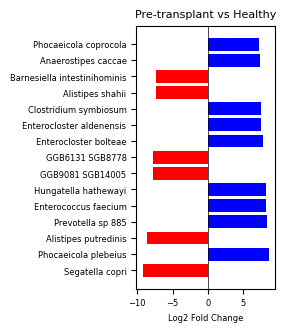

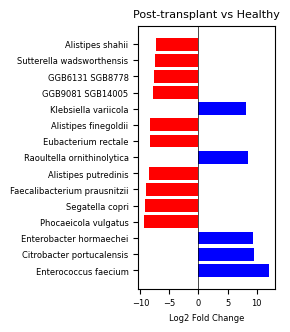

/tmp/ipykernel_11831/3018046821.py:81: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


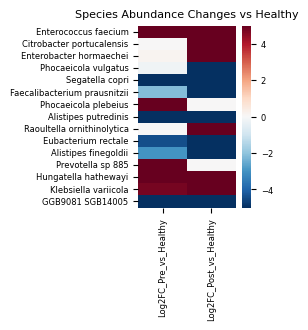

In [31]:
# Calculate differential abundance for Healthy vs Pre and Healthy vs Post
if len(species_data) > 0 and healthy_samples and treated_pre_samples and treated_post_samples:
    # Calculate mean abundances for each group
    healthy_cols = [col for col in species_data.columns if col in healthy_samples]
    pre_cols = [col for col in species_data.columns if col in treated_pre_samples]
    post_cols = [col for col in species_data.columns if col in treated_post_samples]
    
    # Skip if any group is missing
    if not healthy_cols or not pre_cols or not post_cols:
        print("Warning: Missing sample columns for differential abundance analysis")
    else:
        # Calculate mean abundances
        species_means = pd.DataFrame(index=species_data.index)
        species_means['Healthy'] = species_data[healthy_cols].mean(axis=1)
        species_means['Pre'] = species_data[pre_cols].mean(axis=1)
        species_means['Post'] = species_data[post_cols].mean(axis=1)
        
        # Calculate log2 fold changes
        species_means['Log2FC_Pre_vs_Healthy'] = np.log2((species_means['Pre'] + 0.01) / (species_means['Healthy'] + 0.01))
        species_means['Log2FC_Post_vs_Healthy'] = np.log2((species_means['Post'] + 0.01) / (species_means['Healthy'] + 0.01))
        
        # Filter for species with meaningful abundance in at least one group
        meaningful_species = (species_means['Healthy'] >= 0.1) | (species_means['Pre'] >= 0.1) | (species_means['Post'] >= 0.1)
        filtered_means = species_means.loc[meaningful_species]
        
        # Get top differentially abundant species for Pre vs Healthy
        top_pre_healthy_idx = filtered_means['Log2FC_Pre_vs_Healthy'].abs().nlargest(15).index
        top_pre_healthy = filtered_means.loc[top_pre_healthy_idx, ['Log2FC_Pre_vs_Healthy']]
        top_pre_healthy_species = species_data.loc[top_pre_healthy_idx, 'tax_name'].tolist()
        
        # Create bar plot for Pre vs Healthy
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.9, MAX_HEIGHT_INCHES * 0.7))
        plt.barh(
            top_pre_healthy_species,
            top_pre_healthy['Log2FC_Pre_vs_Healthy'],
            color=['red' if x < 0 else 'blue' for x in top_pre_healthy['Log2FC_Pre_vs_Healthy']]
        )
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.title('Pre-transplant vs Healthy')
        plt.xlabel('Log2 Fold Change')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'species_pre_vs_healthy_log2fc.png'), dpi=300)
        plt.show()
        
        # Get top differentially abundant species for Post vs Healthy
        top_post_healthy_idx = filtered_means['Log2FC_Post_vs_Healthy'].abs().nlargest(15).index
        top_post_healthy = filtered_means.loc[top_post_healthy_idx, ['Log2FC_Post_vs_Healthy']]
        top_post_healthy_species = species_data.loc[top_post_healthy_idx, 'tax_name'].tolist()
        
        # Create bar plot for Post vs Healthy
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.9, MAX_HEIGHT_INCHES * 0.7))
        plt.barh(
            top_post_healthy_species,
            top_post_healthy['Log2FC_Post_vs_Healthy'],
            color=['red' if x < 0 else 'blue' for x in top_post_healthy['Log2FC_Post_vs_Healthy']]
        )
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.title('Post-transplant vs Healthy')
        plt.xlabel('Log2 Fold Change')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'species_post_vs_healthy_log2fc.png'), dpi=300)
        plt.show()
        
        # Combined visualization of Pre vs Healthy and Post vs Healthy
        # Get top species that show changes in both comparisons
        combined_log2fc = filtered_means[['Log2FC_Pre_vs_Healthy', 'Log2FC_Post_vs_Healthy']]
        
        # Using .copy() to avoid SettingWithCopyWarning
        combined_log2fc_copy = combined_log2fc.copy()
        combined_log2fc_copy['Max_Abs_FC'] = combined_log2fc_copy.abs().max(axis=1)
        
        top_combined_idx = combined_log2fc_copy.nlargest(15, 'Max_Abs_FC').index
        top_combined = combined_log2fc.loc[top_combined_idx]
        top_combined_species = species_data.loc[top_combined_idx, 'tax_name'].tolist()
        
        # Create heatmap
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.5, MAX_HEIGHT_INCHES * 0.5))
        g = sns.heatmap(top_combined, cmap='RdBu_r', center=0, vmin=-5, vmax=5,
                       yticklabels=top_combined_species)
        plt.title('Species Abundance Changes vs Healthy')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'species_changes_vs_healthy_heatmap.png'), dpi=300)
        plt.show()



Phylum composition raw data:
                               Healthy  Pre-transplant  Post-transplant
Actinobacteria                1.164332        0.631794         0.020030
Ascomycota                    0.007627        0.000281         0.008661
Proteobacteria                2.564720        2.817007        26.700469
Tenericutes                   0.273872        0.000000         0.000000
Firmicutes                   48.847082       46.910151        55.981763
Lentisphaerae                 0.489833        0.000000         0.000000
Verrucomicrobia               4.371662        2.793359         0.000000
Fusobacteria                  0.000000        0.012815         0.001474
Candidatus Saccharibacteria   0.001347        0.000000         0.000000
Eukaryota unclassified        0.083540        0.000000         0.000000
Bacteroidota                 42.175303       46.833752         4.787604
Basidiomycota                 0.000000        0.000000         0.000000
Bacteria unclassified         0.02

<Figure size 188.976x188.976 with 0 Axes>

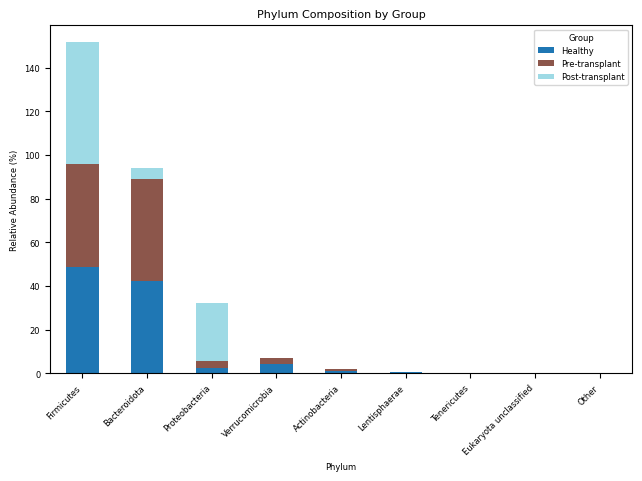

<Figure size 188.976x188.976 with 0 Axes>

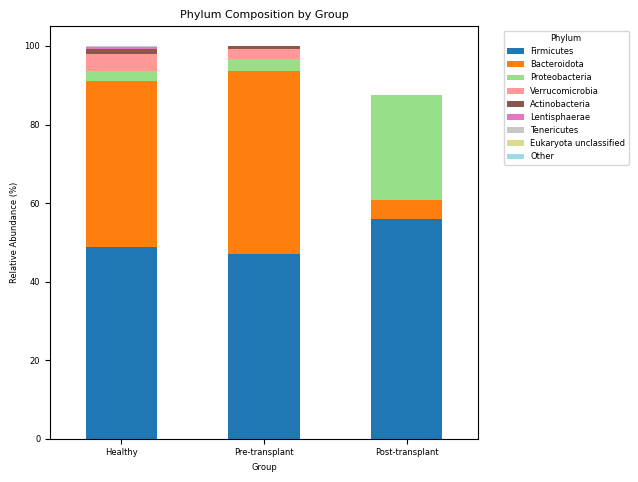


Normalized phylum plot data (percentages):
                          Healthy  Pre-transplant  Post-transplant
Firmicutes              48.847081       46.910151        63.979157
Bacteroidota            42.175301       46.833752         5.471547
Proteobacteria           2.564720        2.817007        30.514821
Verrucomicrobia          4.371662        2.793359         0.000000
Actinobacteria           1.164332        0.631794         0.022891
Lentisphaerae            0.489832        0.000000         0.000000
Tenericutes              0.273872        0.000000         0.000000
Eukaryota unclassified   0.083540        0.000000         0.000000
Other                    0.029657        0.013936         0.011583

Normalized sum by group (should be 100 for each):
Healthy            100.0
Pre-transplant     100.0
Post-transplant    100.0
dtype: float64


<Figure size 188.976x188.976 with 0 Axes>

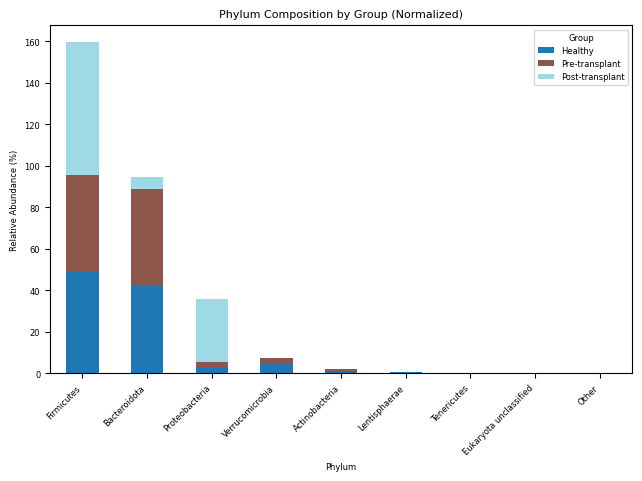

<Figure size 188.976x188.976 with 0 Axes>

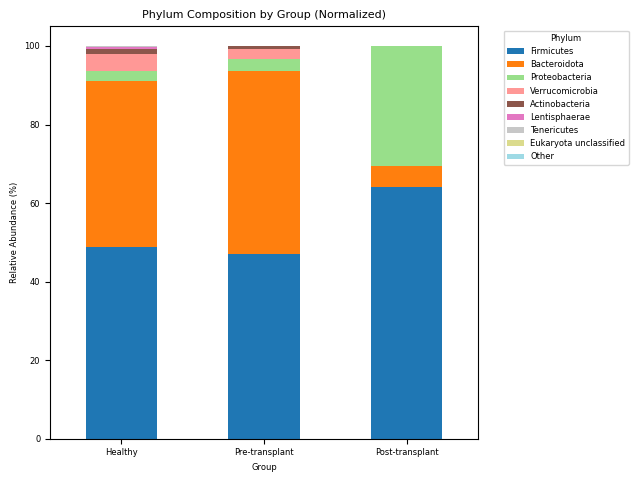

In [ ]:
# Phylum composition comparison: Healthy vs Pre vs Post
if len(phylum_data) > 0 and healthy_samples and treated_pre_samples and treated_post_samples:
    # Calculate mean abundances for each group
    phylum_means = pd.DataFrame(index=phylum_data.index)
    
    # Get sample columns for each group
    healthy_cols = [col for col in phylum_data.columns if col in healthy_samples]
    pre_cols = [col for col in phylum_data.columns if col in treated_pre_samples]
    post_cols = [col for col in phylum_data.columns if col in treated_post_samples]
    
    # Calculate means if sample columns exist
    if healthy_cols:
        phylum_means['Healthy'] = phylum_data[healthy_cols].mean(axis=1)
    if pre_cols:
        phylum_means['Pre-transplant'] = phylum_data[pre_cols].mean(axis=1)
    if post_cols:
        phylum_means['Post-transplant'] = phylum_data[post_cols].mean(axis=1)
    
    # Skip if any group is missing
    if 'Healthy' not in phylum_means.columns or 'Pre-transplant' not in phylum_means.columns or 'Post-transplant' not in phylum_means.columns:
        print("Warning: Missing sample columns for phylum composition analysis")
    else:
        # Get phylum names
        phylum_means['Phylum'] = phylum_data['tax_name']
        
        # Sum abundances for each phylum
        phylum_pivot = pd.DataFrame(columns=['Healthy', 'Pre-transplant', 'Post-transplant'])
        for phylum in phylum_means['Phylum'].unique():
            phylum_rows = phylum_means[phylum_means['Phylum'] == phylum]
            phylum_pivot.loc[phylum] = phylum_rows[['Healthy', 'Pre-transplant', 'Post-transplant']].sum()
        
        # Add debugging information
        print("\nPhylum composition raw data:")
        print(phylum_pivot)
        print("\nSum by group:")
        print(phylum_pivot.sum())
        
        # Get top phyla and group others as "Other"
        phylum_pivot['Total'] = phylum_pivot.sum(axis=1)
        top_phyla = phylum_pivot.nlargest(8, 'Total').index.tolist()  # Convert to list to avoid set issue
        phylum_plot = phylum_pivot.loc[top_phyla, ['Healthy', 'Pre-transplant', 'Post-transplant']]
        
        # Add "Other" category if needed
        other_phyla = [p for p in phylum_pivot.index.tolist() if p not in top_phyla]  # Use list comprehension instead of set difference
        if other_phyla:
            phylum_plot.loc['Other'] = phylum_pivot.loc[other_phyla, ['Healthy', 'Pre-transplant', 'Post-transplant']].sum()
        
        # Print debug information for the final plot data
        print("\nFinal phylum plot data:")
        print(phylum_plot)
        print("\nFinal sum by group:")
        print(phylum_plot.sum())
        
        # Create stacked bar plot
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.6, MAX_HEIGHT_INCHES * 0.4))
        phylum_plot.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('Phylum Composition by Group')
        plt.xlabel('Phylum')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Relative Abundance (%)')
        plt.legend(title='Group')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'phylum_composition_by_group.png'), dpi=300)
        plt.show()
        
        # Create stacked bar plot (transposed)
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.6, MAX_HEIGHT_INCHES * 0.4))
        phylum_plot.T.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('Phylum Composition by Group')
        plt.xlabel('Group')
        plt.xticks(rotation=0)
        plt.ylabel('Relative Abundance (%)')
        plt.legend(title='Phylum', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'phylum_composition_by_group_transposed.png'), dpi=300)
        plt.show()
        
        # Create normalised versions of the plots (to ensure each column sums to 100%)
        phylum_plot_percent = phylum_plot.copy()
        for col in phylum_plot_percent.columns:
            col_sum = phylum_plot_percent[col].sum()
            if col_sum > 0:  # Avoid division by zero
                phylum_plot_percent[col] = (phylum_plot_percent[col] / col_sum) * 100
        
        # Print normalised data
        print("\nNormalised phylum plot data (percentages):")
        print(phylum_plot_percent)
        print("\nNormalised sum by group (should be 100 for each):")
        print(phylum_plot_percent.sum())
        
        # Create normalised stacked bar plot
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.6, MAX_HEIGHT_INCHES * 0.4))
        phylum_plot_percent.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('Phylum Composition by Group (Normalised)')
        plt.xlabel('Phylum')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Relative Abundance (%)')
        plt.legend(title='Group')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'phylum_composition_by_group_normalised.png'), dpi=300)
        plt.show()
        
        # Create normalised stacked bar plot (transposed)
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.6, MAX_HEIGHT_INCHES * 0.4))
        phylum_plot_percent.T.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('Phylum Composition by Group (Normalised)')
        plt.xlabel('Group')
        plt.xticks(rotation=0)
        plt.ylabel('Relative Abundance (%)')
        plt.legend(title='Phylum', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'phylum_composition_by_group_transposed_normalised.png'), dpi=300)
        plt.show()


Genus composition raw data:
                          Healthy  Pre-transplant  Post-transplant
Clostridia unclassified  0.000000        0.033028         0.000000
Lacrimispora             0.107995        0.089959         0.000000
Streptococcus            0.061190        0.387788         1.389339
GGB2982                  0.006305        0.000000         0.000000
GGB9301                  0.000063        0.000000         0.000000
...                           ...             ...              ...
Prevotella               0.000000        3.125679         0.000212
GGB58158                 0.000030        0.000000         0.000000
Neglectibacter           0.000000        0.001785         0.000000
Lachnoclostridium        0.002992        1.905719         0.044698
GGB9707                  0.075655        0.000000         0.000000

[349 rows x 3 columns]

Sum by group:
Healthy            100.000007
Pre-transplant      99.999998
Post-transplant     87.500003
dtype: float64

Final genus plot data:

<Figure size 188.976x188.976 with 0 Axes>

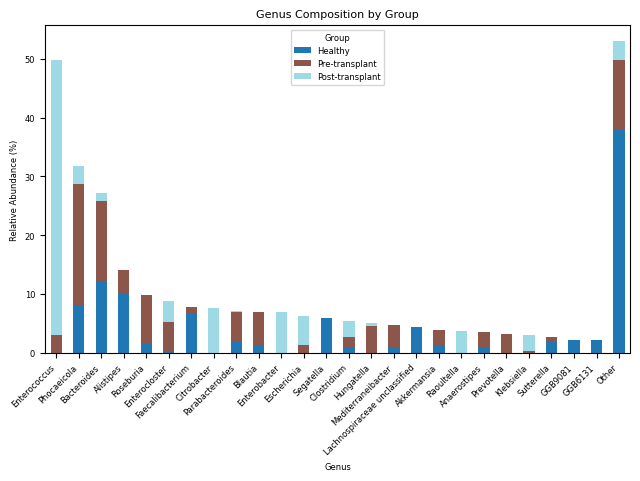

<Figure size 188.976x188.976 with 0 Axes>

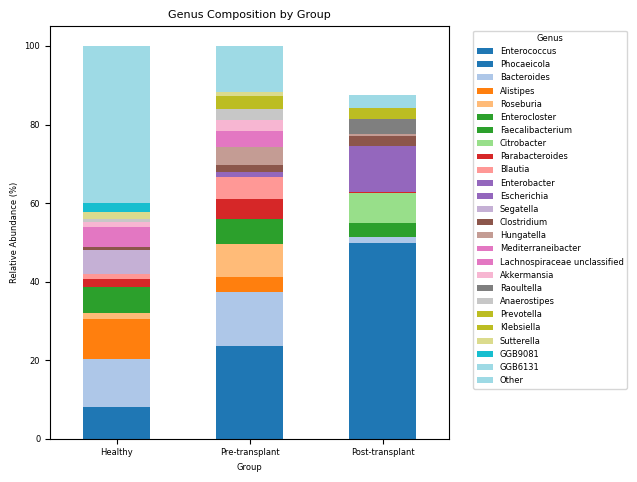


Normalized genus plot data (percentages):
                                Healthy  Pre-transplant  Post-transplant
Enterococcus                   0.000000        3.025444        53.394924
Phocaeicola                    8.062974       20.571124         3.635431
Bacteroides                   12.172169       13.676919         1.545753
Alistipes                     10.239094        3.867419         0.000000
Roseburia                      1.457105        8.414146         0.000000
Enterocloster                  0.117002        5.192184         4.069243
Faecalibacterium               6.671547        1.123809         0.000000
Citrobacter                    0.011992        0.022995         8.758300
Parabacteroides                1.856807        5.080265         0.287400
Blautia                        1.373505        5.560750         0.000067
Enterobacter                   0.000000        0.002415         7.830141
Escherichia                    0.022607        1.381858         5.560633
Segatell

<Figure size 188.976x188.976 with 0 Axes>

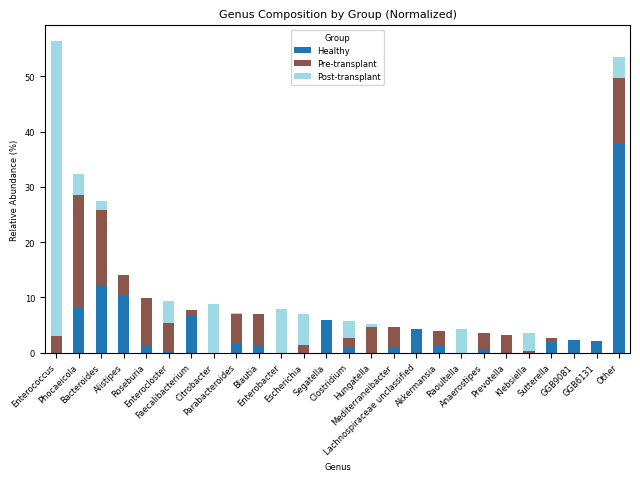

<Figure size 188.976x188.976 with 0 Axes>

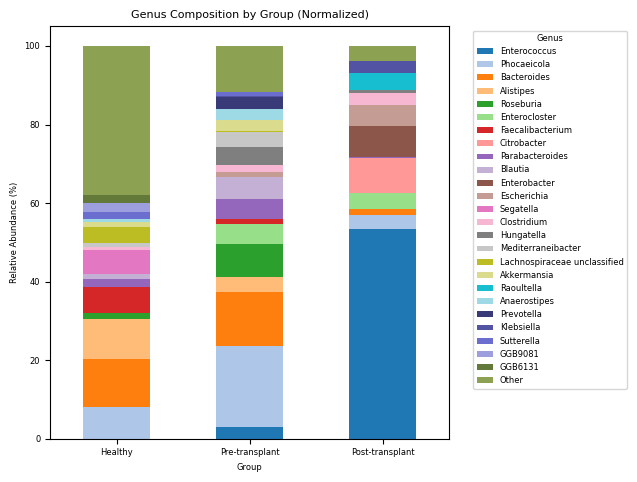

In [ ]:
# Genus composition comparison: Healthy vs Pre vs Post
if len(genus_data) > 0 and healthy_samples and treated_pre_samples and treated_post_samples:
    # Calculate mean abundances for each group
    genus_means = pd.DataFrame(index=genus_data.index)
    
    # Get sample columns for each group
    healthy_cols = [col for col in genus_data.columns if col in healthy_samples]
    pre_cols = [col for col in genus_data.columns if col in treated_pre_samples]
    post_cols = [col for col in genus_data.columns if col in treated_post_samples]
    
    # Calculate means if sample columns exist
    if healthy_cols:
        genus_means['Healthy'] = genus_data[healthy_cols].mean(axis=1)
    if pre_cols:
        genus_means['Pre-transplant'] = genus_data[pre_cols].mean(axis=1)
    if post_cols:
        genus_means['Post-transplant'] = genus_data[post_cols].mean(axis=1)
    
    # Skip if any group is missing
    if 'Healthy' not in genus_means.columns or 'Pre-transplant' not in genus_means.columns or 'Post-transplant' not in genus_means.columns:
        print("Warning: Missing sample columns for genus composition analysis")
    else:
        # Get genus names
        genus_means['Genus'] = genus_data['tax_name']
        
        # Sum abundances for each genus
        genus_pivot = pd.DataFrame(columns=['Healthy', 'Pre-transplant', 'Post-transplant'])
        for genus in genus_means['Genus'].unique():
            genus_rows = genus_means[genus_means['Genus'] == genus]
            genus_pivot.loc[genus] = genus_rows[['Healthy', 'Pre-transplant', 'Post-transplant']].sum()
        
        # Add debugging information
        print("\nGenus composition raw data:")
        print(genus_pivot)
        print("\nSum by group:")
        print(genus_pivot.sum())
        
        # Get top genera and group others as "Other"
        genus_pivot['Total'] = genus_pivot.sum(axis=1)
        top_genera = genus_pivot.nlargest(25, 'Total').index.tolist() # number of top genera to include
        genus_plot = genus_pivot.loc[top_genera, ['Healthy', 'Pre-transplant', 'Post-transplant']]
        
        # Add "Other" category if needed
        other_genera = [g for g in genus_pivot.index.tolist() if g not in top_genera]  # Use list comprehension instead of set difference
        if other_genera:
            genus_plot.loc['Other'] = genus_pivot.loc[other_genera, ['Healthy', 'Pre-transplant', 'Post-transplant']].sum()
        
        # Print debug information for the final plot data
        print("\nFinal genus plot data:")
        print(genus_plot)
        print("\nFinal sum by group:")
        print(genus_plot.sum())

         # Create normalised versions of the plots (to ensure each column sums to 100%)
        genus_plot_percent = genus_plot.copy()
        for col in genus_plot_percent.columns:
            col_sum = genus_plot_percent[col].sum()
            if col_sum > 0:  # Avoid division by zero
                genus_plot_percent[col] = (genus_plot_percent[col] / col_sum) * 100

        # Ensure enough colours
        # Count how many genera we need colors for
        n_genera = len(genus_plot_percent.index)

        # Combination of colormaps approach - simple but effective
        # Use tab20 (20 colors) + tab20b (20 more colors) + tab20c (20 more colors)
        tab20_colours = plt.cm.tab20.colors  # 20 colors
        tab20b_colours = plt.cm.tab20b.colors  # 20 more colors
        tab20c_colours = plt.cm.tab20c.colors  # 20 more colors

        # Combine all colors and take as many as needed
        all_colors = list(tab20_colours) + list(tab20b_colours) + list(tab20c_colours)
        colours_needed = all_colors[:n_genera]
        
        # Create stacked bar plot
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.6, MAX_HEIGHT_INCHES * 0.4))
        genus_plot.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('Genus Composition by Group')
        plt.xlabel('Genus')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Relative Abundance (%)')
        plt.legend(title='Group')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'genus_composition_by_group.png'), dpi=300)
        plt.show()
        
        # Create stacked bar plot (transposed)
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.6, MAX_HEIGHT_INCHES * 0.4))
        genus_plot.T.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('Genus Composition by Group')
        plt.xlabel('Group')
        plt.xticks(rotation=0)
        plt.ylabel('Relative Abundance (%)')
        plt.legend(title='Genus', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'genus_composition_by_group_transposed.png'), dpi=300)
        plt.show()
        
       
        
        # Print normalised data
        print("\nNormalised genus plot data (percentages):")
        print(genus_plot_percent)
        print("\nNormalised sum by group (should be 100 for each):")
        print(genus_plot_percent.sum())
        
        # Create normalised stacked bar plot
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.6, MAX_HEIGHT_INCHES * 0.4))
        genus_plot_percent.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('Genus Composition by Group (Normalised)')
        plt.xlabel('Genus')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Relative Abundance (%)')
        plt.legend(title='Group')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'genus_composition_by_group_normalised.png'), dpi=300)
        plt.show()
        
        # Create normalised stacked bar plot (transposed)
        plt.figure(figsize=(MAX_WIDTH_INCHES * 0.6, MAX_HEIGHT_INCHES * 0.4))
        genus_plot_percent.T.plot(kind='bar', stacked=True, color=colours_needed)
        plt.title('Genus Composition by Group (Normalised)')
        plt.xlabel('Group')
        plt.xticks(rotation=0)
        plt.ylabel('Relative Abundance (%)')
        plt.legend(title='Genus', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'genus_composition_by_group_transposed_normalised.jpeg'), dpi=300)
        plt.show()

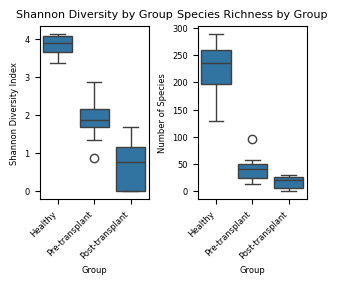

In [43]:
# Diversity metrics comparison: Healthy vs Pre vs Post
if len(species_data) > 0 and healthy_samples and treated_pre_samples and treated_post_samples:
    # Calculate diversity metrics for each sample
    diversity_data = []
    
    # Process all samples
    all_samples = healthy_samples + treated_pre_samples + treated_post_samples
    for sample in all_samples:
        # Skip if sample not in species data
        if sample not in species_data.columns:
            continue
        
        # Get sample type
        sample_type = None
        if sample in healthy_samples:
            sample_type = 'Healthy'
        elif sample in treated_pre_samples:
            sample_type = 'Pre-transplant'
        elif sample in treated_post_samples:
            sample_type = 'Post-transplant'
        else:
            continue
        
        # Get abundance values
        abundances = species_data[sample].values
        
        # Shannon diversity
        abundances_norm = abundances / (abundances.sum() or 1)
        abundances_norm = abundances_norm[abundances_norm > 0]
        shannon = -np.sum(abundances_norm * np.log(abundances_norm))
        
        # Richness
        richness = np.sum(abundances > 0)
        
        # Store data
        diversity_data.append({
            'Sample': sample,
            'Group': sample_type,
            'Shannon': shannon,
            'Richness': richness
        })
    
    # Create diversity DataFrame
    diversity_df = pd.DataFrame(diversity_data)
    
    # Create boxplots
    plt.figure(figsize=(MAX_WIDTH_INCHES, MAX_HEIGHT_INCHES * 0.6))
    
    # Shannon diversity
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Group', y='Shannon', data=diversity_df, order=['Healthy', 'Pre-transplant', 'Post-transplant'])
    plt.title('Shannon Diversity by Group')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Shannon Diversity Index')
    
    # Richness
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Group', y='Richness', data=diversity_df, order=['Healthy', 'Pre-transplant', 'Post-transplant'])
    plt.title('Species Richness by Group')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Species')
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'diversity_metrics_by_group.png'), dpi=300)
    plt.show()
    
    # Calculate statistics - handle potential empty group issue
    try:
        # Format: t-statistic, p-value
        stats_results = {
            'Shannon': {
                'Healthy_vs_Pre': stats.ttest_ind(
                    diversity_df[diversity_df['Group'] == 'Healthy']['Shannon'],
                    diversity_df[diversity_df['Group'] == 'Pre-transplant']['Shannon']
                ),
                'Healthy_vs_Post': stats.ttest_ind(
                    diversity_df[diversity_df['Group'] == 'Healthy']['Shannon'],
                    diversity_df[diversity_df['Group'] == 'Post-transplant']['Shannon']
                ),
                'Pre_vs_Post': stats.ttest_ind(
                    diversity_df[diversity_df['Group'] == 'Pre-transplant']['Shannon'],
                    diversity_df[diversity_df['Group'] == 'Post-transplant']['Shannon']
                )
            },
            'Richness': {
                'Healthy_vs_Pre': stats.ttest_ind(
                    diversity_df[diversity_df['Group'] == 'Healthy']['Richness'],
                    diversity_df[diversity_df['Group'] == 'Pre-transplant']['Richness']
                ),
                'Healthy_vs_Post': stats.ttest_ind(
                    diversity_df[diversity_df['Group'] == 'Healthy']['Richness'],
                    diversity_df[diversity_df['Group'] =='Post-transplant']['Richness']
                ),
                'Pre_vs_Post': stats.ttest_ind(
                    diversity_df[diversity_df['Group'] == 'Pre-transplant']['Richness'],
                    diversity_df[diversity_df['Group'] == 'Post-transplant']['Richness']
                )
            }
        }
        
        # Save statistics to a text file
        with open(os.path.join(plots_dir, 'diversity_statistics.txt'), 'w') as f:
            f.write("DIVERSITY METRICS STATISTICAL ANALYSIS\n")
            f.write("=====================================\n\n")
            
            f.write("Shannon Diversity:\n")
            f.write("----------------\n")
            f.write(f"Healthy vs Pre-transplant: t={stats_results['Shannon']['Healthy_vs_Pre'][0]:.3f}, p={stats_results['Shannon']['Healthy_vs_Pre'][1]:.4f}")
            f.write(f" ({'Significant' if stats_results['Shannon']['Healthy_vs_Pre'][1] < 0.05 else 'Not significant'})\n")
            
            f.write(f"Healthy vs Post-transplant: t={stats_results['Shannon']['Healthy_vs_Post'][0]:.3f}, p={stats_results['Shannon']['Healthy_vs_Post'][1]:.4f}")
            f.write(f" ({'Significant' if stats_results['Shannon']['Healthy_vs_Post'][1] < 0.05 else 'Not significant'})\n")
            
            f.write(f"Pre-transplant vs Post-transplant: t={stats_results['Shannon']['Pre_vs_Post'][0]:.3f}, p={stats_results['Shannon']['Pre_vs_Post'][1]:.4f}")
            f.write(f" ({'Significant' if stats_results['Shannon']['Pre_vs_Post'][1] < 0.05 else 'Not significant'})\n\n")
            
            f.write("Species Richness:\n")
            f.write("----------------\n")
            f.write(f"Healthy vs Pre-transplant: t={stats_results['Richness']['Healthy_vs_Pre'][0]:.3f}, p={stats_results['Richness']['Healthy_vs_Pre'][1]:.4f}")
            f.write(f" ({'Significant' if stats_results['Richness']['Healthy_vs_Pre'][1] < 0.05 else 'Not significant'})\n")
            
            f.write(f"Healthy vs Post-transplant: t={stats_results['Richness']['Healthy_vs_Post'][0]:.3f}, p={stats_results['Richness']['Healthy_vs_Post'][1]:.4f}")
            f.write(f" ({'Significant' if stats_results['Richness']['Healthy_vs_Post'][1] < 0.05 else 'Not significant'})\n")
            
            f.write(f"Pre-transplant vs Post-transplant: t={stats_results['Richness']['Pre_vs_Post'][0]:.3f}, p={stats_results['Richness']['Pre_vs_Post'][1]:.4f}")
            f.write(f" ({'Significant' if stats_results['Richness']['Pre_vs_Post'][1] < 0.05 else 'Not significant'})\n")
    except Exception as e:
        print(f"Warning: Could not complete statistical tests: {e}")

### PCA 

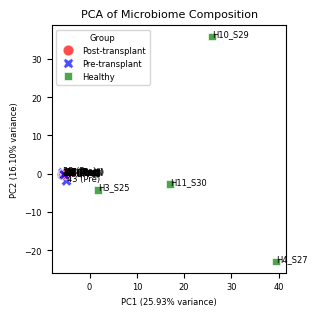

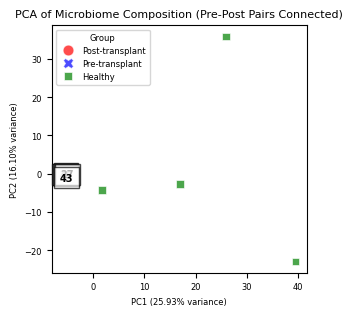

In [45]:
# PCA analysis of all samples
if len(species_data) > 0:
    try:
        # Get all samples
        all_samples = healthy_samples + treated_pre_samples + treated_post_samples
        sample_cols = [col for col in species_data.columns if col in all_samples]
        
        if len(sample_cols) >= 3:  # Need at least 3 samples for meaningful PCA
            # Prepare matrix for PCA
            pca_data = species_data[sample_cols].T
            
            # Standardize the data
            scaler = StandardScaler()
            pca_data_scaled = scaler.fit_transform(pca_data)
            
            # Perform PCA
            pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
            pca_result = pca.fit_transform(pca_data_scaled)
            
            # Create DataFrame with PCA results
            pca_df = pd.DataFrame({
                'PC1': pca_result[:, 0],
                'PC2': pca_result[:, 1],
                'Sample': sample_cols
            })
            
            # Add group information
            pca_df['Group'] = pca_df['Sample'].apply(
                lambda x: 'Healthy' if x in healthy_samples else 
                          'Pre-transplant' if x in treated_pre_samples else 
                          'Post-transplant' if x in treated_post_samples else 'Other'
            )
            
            # Add patient information
            pca_df['Patient'] = 'Unknown'
            for sample in pca_df['Sample']:
                for patient, samples in patient_samples.items():
                    if sample in samples['pre'] or sample in samples['post']:
                        pca_df.loc[pca_df['Sample'] == sample, 'Patient'] = patient
                        break
            
            # Create PCA plot
            plt.figure(figsize=(MAX_WIDTH_INCHES * 1, MAX_WIDTH_INCHES * 1))
            
            # Plot by group
            sns.scatterplot(
                x='PC1', y='PC2', hue='Group', 
                style='Group',
                palette={'Healthy': 'green', 'Pre-transplant': 'blue', 'Post-transplant': 'red'},
                data=pca_df, s=60, alpha=0.7
            )
            
            # Add sample labels
            for idx, row in pca_df.iterrows():
                # Simplify sample name for display
                if row['Group'] == 'Healthy':
                    label = row['Sample']
                else:
                    label = f"{row['Patient']} ({'Pre' if row['Group'] == 'Pre-transplant' else 'Post'})"
                
                plt.text(row['PC1'] + 0.02, row['PC2'] + 0.02, label, fontsize=6)
            
            # Add explained variance information
            plt.title('PCA of Microbiome Composition')
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, 'pca_all_samples.png'), dpi=300)
            plt.show()
            
            # Create connected PCA plot for pre-post pairs
            plt.figure(figsize=(MAX_WIDTH_INCHES * 1, MAX_WIDTH_INCHES * 1))
            
            # Plot all points first
            sns.scatterplot(
                x='PC1', y='PC2', hue='Group',
                style='Group',
                palette={'Healthy': 'green', 'Pre-transplant': 'blue', 'Post-transplant': 'red'},
                data=pca_df, s=60, alpha=0.7
            )
            
            # Add lines connecting pre-post pairs
            for patient in patients_with_both:
                pre_sample = patient_samples[patient]['pre'][0] if patient_samples[patient]['pre'] else None
                post_sample = patient_samples[patient]['post'][0] if patient_samples[patient]['post'] else None
                
                if pre_sample in pca_df['Sample'].values and post_sample in pca_df['Sample'].values:
                    pre_row = pca_df[pca_df['Sample'] == pre_sample].iloc[0]
                    post_row = pca_df[pca_df['Sample'] == post_sample].iloc[0]
                    
                    plt.plot([pre_row['PC1'], post_row['PC1']], [pre_row['PC2'], post_row['PC2']], 
                             'k--', alpha=0.5)
                    
                    # Add patient label in the middle of the line
                    mid_x = (pre_row['PC1'] + post_row['PC1']) / 2
                    mid_y = (pre_row['PC2'] + post_row['PC2']) / 2
                    plt.text(mid_x, mid_y, patient, fontsize=7, fontweight='bold', 
                             ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
            
            plt.title('PCA of Microbiome Composition (Pre-Post Pairs Connected)')
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, 'pca_paired_samples.png'), dpi=300)
            plt.show()
    except Exception as e:
        print(f"Warning: Could not complete PCA analysis: {e}")

### Species abundance plots

Found 87 species with meaningful abundance across all patients


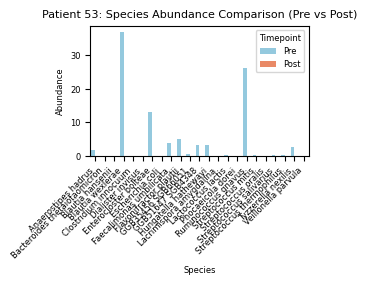

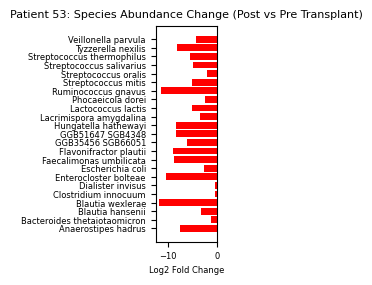

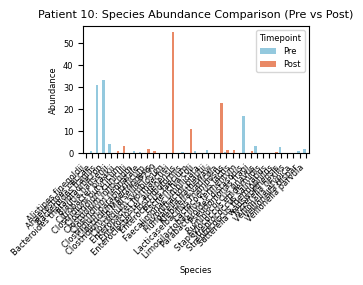

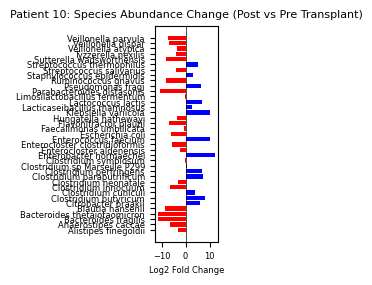

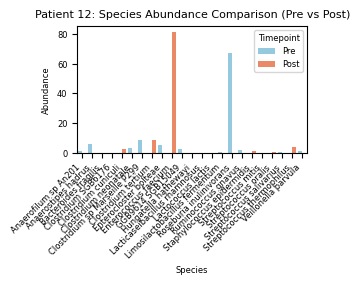

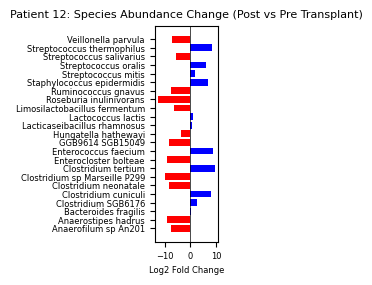

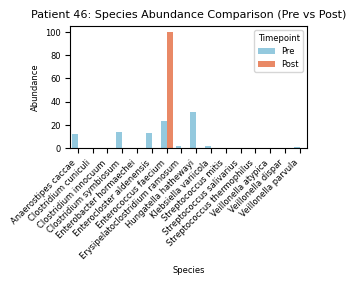

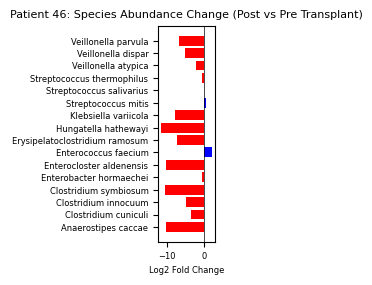

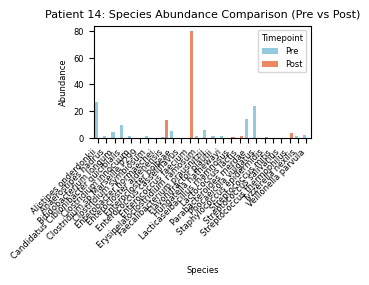

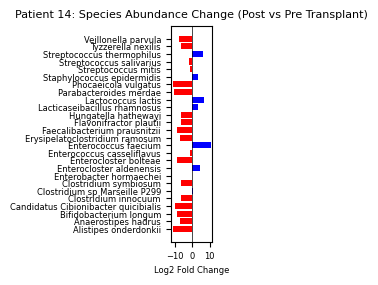

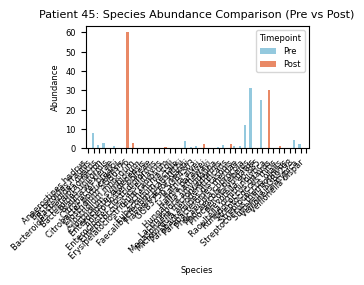

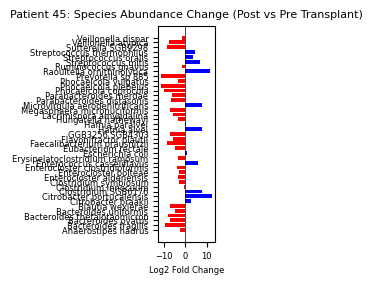

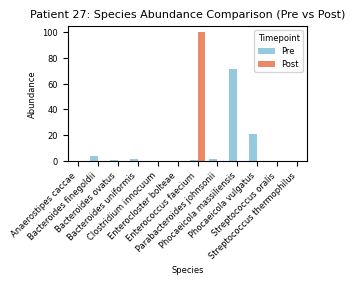

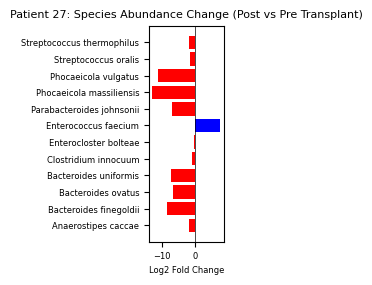

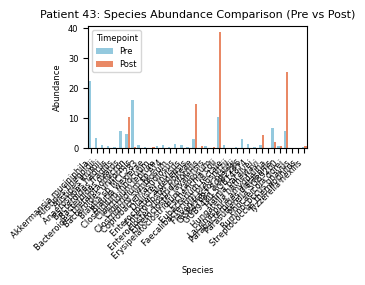

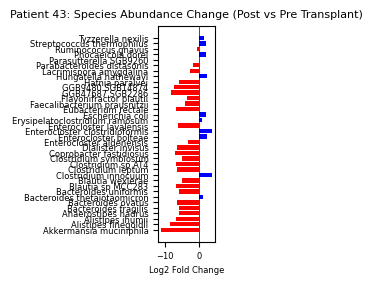

In [36]:
# Get all species with meaningful abundance across patients
all_species = set()
for patient in patients_with_both:
    pre_sample = patient_samples[patient]['pre'][0] if patient_samples[patient]['pre'] else None
    post_sample = patient_samples[patient]['post'][0] if patient_samples[patient]['post'] else None
    
    if pre_sample and post_sample and pre_sample in species_data.columns and post_sample in species_data.columns:
        # Get species data for this patient
        patient_species_data = species_data[[pre_sample, post_sample, 'tax_name']]
        
        # Filter for species with abundance > 0.5% in either pre or post
        has_abundance = (patient_species_data[pre_sample] > 0.5) | (patient_species_data[post_sample] > 0.5)
        species_with_abundance = patient_species_data[has_abundance]['tax_name'].tolist()
        all_species.update(species_with_abundance)

# Sort all species alphabetically
all_species = sorted(list(all_species))
print(f"Found {len(all_species)} species with meaningful abundance across all patients")

# Function to create species abundance plots for a patient
def create_patient_abundance_plot(patient, species_list=None, sort_alphabetically=True):
    pre_sample = patient_samples[patient]['pre'][0] if patient_samples[patient]['pre'] else None
    post_sample = patient_samples[patient]['post'][0] if patient_samples[patient]['post'] else None
    
    # Skip if samples not found
    if not pre_sample or not post_sample or pre_sample not in species_data.columns or post_sample not in species_data.columns:
        print(f"Warning: Missing samples for patient {patient}")
        return
    
    # Get species data for this patient
    patient_species_data = species_data[[pre_sample, post_sample, 'tax_name']]
    
    # Filter for species with abundance > 0 in either pre or post
    has_abundance = (patient_species_data[pre_sample] > 0) | (patient_species_data[post_sample] > 0)
    patient_species_data = patient_species_data[has_abundance]
    
    # If species list is not provided, get top species for this patient
    if species_list is None:
        species_sum = patient_species_data[pre_sample] + patient_species_data[post_sample]
        top_species_idx = species_sum.nlargest(15).index
        species_list = patient_species_data.loc[top_species_idx, 'tax_name'].tolist()
    
    # Filter data for the selected species
    plot_data = []
    for species in species_list:
        species_rows = patient_species_data[patient_species_data['tax_name'] == species]
        if not species_rows.empty:
            idx = species_rows.index[0]
            pre_val = patient_species_data.loc[idx, pre_sample]
            post_val = patient_species_data.loc[idx, post_sample]
            
            plot_data.append({
                'Species': species,
                'Timepoint': 'Pre',
                'Abundance': pre_val
            })
            
            plot_data.append({
                'Species': species,
                'Timepoint': 'Post',
                'Abundance': post_val
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Sort alphabetically if requested
    if sort_alphabetically:
        plot_df['Species'] = pd.Categorical(plot_df['Species'], categories=sorted(plot_df['Species'].unique()), ordered=True)
    
    # Create the plot
    plt.figure(figsize=(MAX_WIDTH_INCHES, MAX_HEIGHT_INCHES * 0.6))
    ax = sns.barplot(x='Species', y='Abundance', hue='Timepoint', data=plot_df,
                   palette={'Pre': 'skyblue', 'Post': 'coral'})
    
    plt.title(f'Patient {patient}: Species Abundance Comparison (Pre vs Post)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'patient_{patient}_abundance_comparison.png'), dpi=300)
    plt.show()
    
    return plot_df['Species'].unique()

# Function to create fold change plots for a patient
def create_patient_foldchange_plot(patient, species_list=None, sort_alphabetically=True, reverse_sort=False):  # Changed to False to have A at the top
    pre_sample = patient_samples[patient]['pre'][0] if patient_samples[patient]['pre'] else None
    post_sample = patient_samples[patient]['post'][0] if patient_samples[patient]['post'] else None
    
    # Skip if samples not found
    if not pre_sample or not post_sample or pre_sample not in species_data.columns or post_sample not in species_data.columns:
        print(f"Warning: Missing samples for patient {patient}")
        return
    
    # Get species data for this patient
    patient_species_data = species_data[[pre_sample, post_sample, 'tax_name']]
    
    # Filter for species with abundance > 0 in either pre or post
    has_abundance = (patient_species_data[pre_sample] > 0) | (patient_species_data[post_sample] > 0)
    patient_species_data = patient_species_data[has_abundance]
    
    # If species list is not provided, get top species for this patient
    if species_list is None:
        species_sum = patient_species_data[pre_sample] + patient_species_data[post_sample]
        top_species_idx = species_sum.nlargest(15).index
        species_list = patient_species_data.loc[top_species_idx, 'tax_name'].tolist()
    
    # Calculate log2 fold changes
    log2fc_data = []
    for species in species_list:
        species_rows = patient_species_data[patient_species_data['tax_name'] == species]
        if not species_rows.empty:
            idx = species_rows.index[0]
            pre_val = patient_species_data.loc[idx, pre_sample]
            post_val = patient_species_data.loc[idx, post_sample]
            fc = np.log2((post_val + 0.01) / (pre_val + 0.01))
            
            log2fc_data.append({
                'Species': species,
                'Log2FC': fc
            })
    
    log2fc_df = pd.DataFrame(log2fc_data)
    
    # Sort alphabetically if requested
    if sort_alphabetically:
        if reverse_sort:  # Reverse alphabetical order as requested
            log2fc_df['Species'] = pd.Categorical(log2fc_df['Species'], 
                                              categories=sorted(log2fc_df['Species'].unique(), reverse=True), 
                                              ordered=True)
        else:
            log2fc_df['Species'] = pd.Categorical(log2fc_df['Species'], 
                                              categories=sorted(log2fc_df['Species'].unique()), 
                                              ordered=True)
    
    # Create the plot
    plt.figure(figsize=(MAX_WIDTH_INCHES * 0.7, MAX_HEIGHT_INCHES * 0.6))
    bars = plt.barh(
        log2fc_df['Species'], 
        log2fc_df['Log2FC'],
        color=['red' if x < 0 else 'blue' for x in log2fc_df['Log2FC']]
    )
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.title(f'Patient {patient}: Species Abundance Change (Post vs Pre Transplant)')
    plt.xlabel('Log2 Fold Change')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'patient_{patient}_log2fc.png'), dpi=300)
    plt.show()

# Create individual patient plots
for patient in patients_with_both:
    create_patient_abundance_plot(patient, all_species)
    create_patient_foldchange_plot(patient, all_species, reverse_sort=False)  # Changed to False to have A at the top


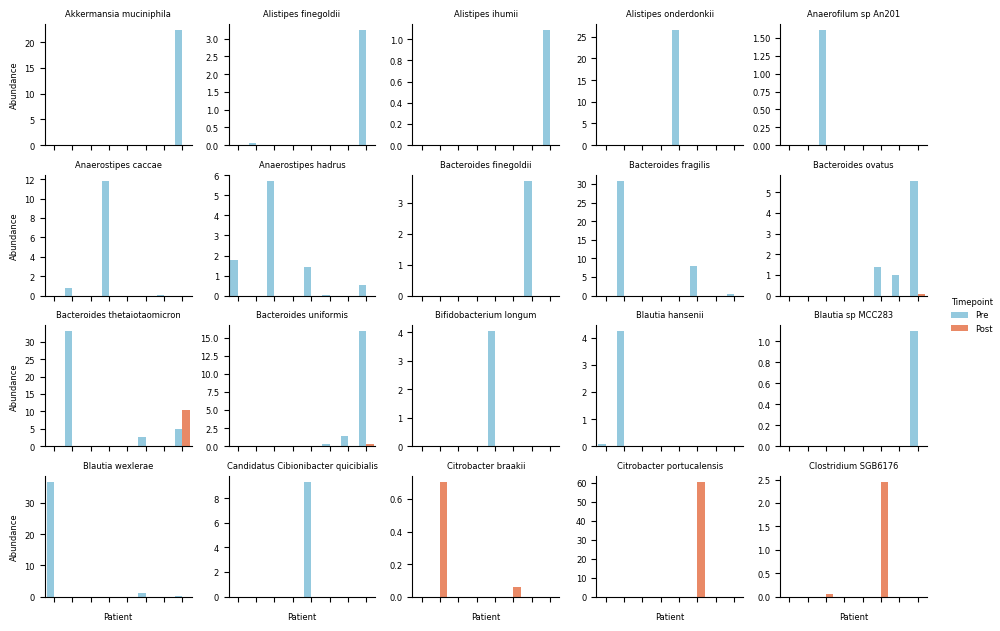

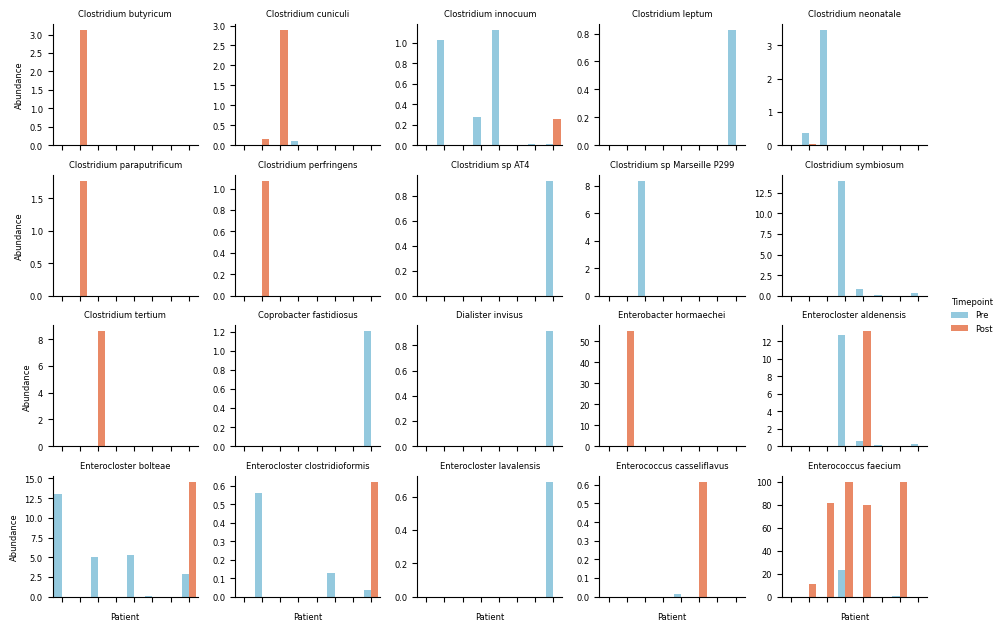

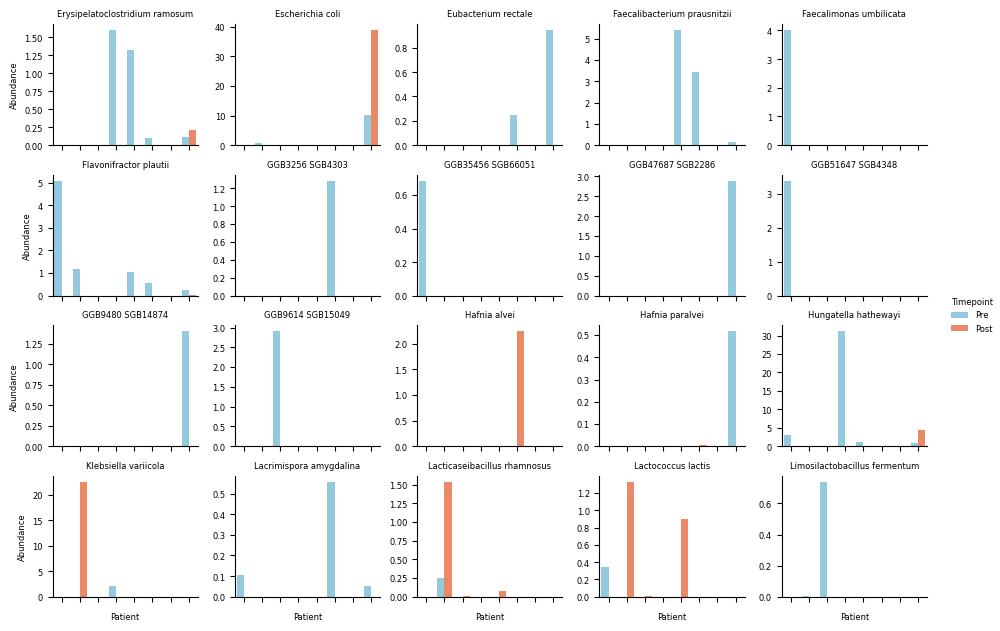

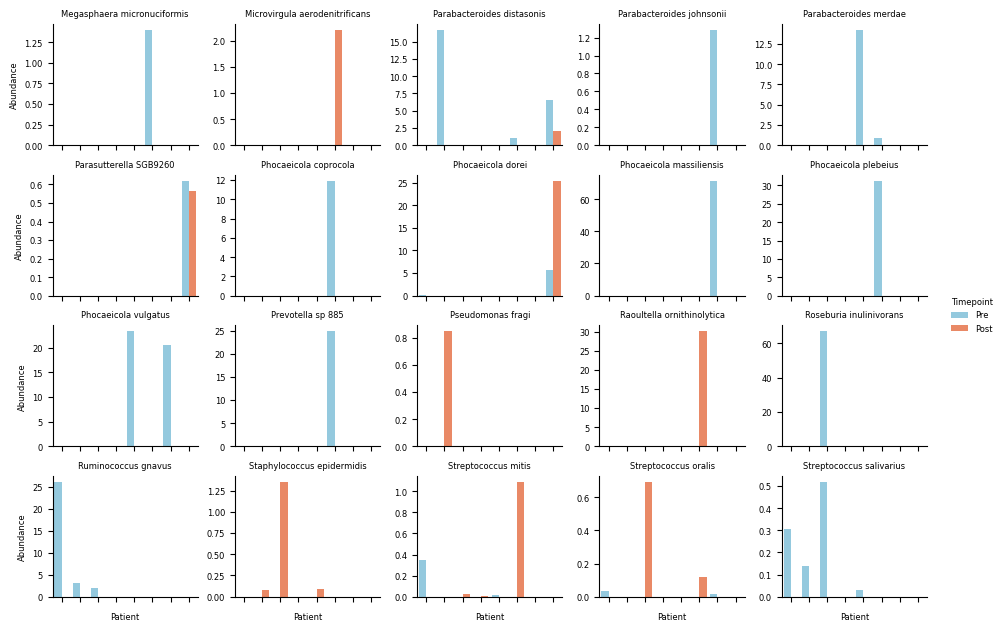

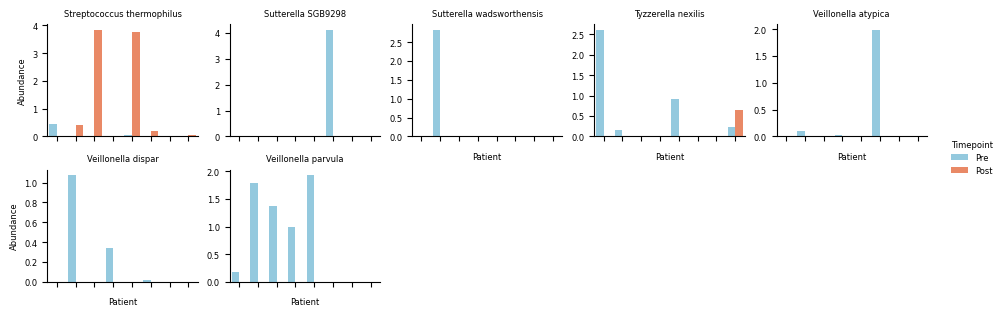

In [37]:
# Combined species abundance plots
# Prepare data for combined plot
combined_abundance_data = []

for patient in patients_with_both:
    pre_sample = patient_samples[patient]['pre'][0] if patient_samples[patient]['pre'] else None
    post_sample = patient_samples[patient]['post'][0] if patient_samples[patient]['post'] else None
    
    if pre_sample and post_sample and pre_sample in species_data.columns and post_sample in species_data.columns:
        for species in all_species:
            # Find the species in the data
            species_rows = species_data[species_data['tax_name'] == species]
            if not species_rows.empty:
                idx = species_rows.index[0]
                pre_val = species_data.loc[idx, pre_sample]
                post_val = species_data.loc[idx, post_sample]
                
                combined_abundance_data.append({
                    'Species': species,
                    'Patient': patient,
                    'Timepoint': 'Pre',
                    'Abundance': pre_val
                })
                
                combined_abundance_data.append({
                    'Species': species,
                    'Patient': patient,
                    'Timepoint': 'Post',
                    'Abundance': post_val
                })

combined_df = pd.DataFrame(combined_abundance_data)

# Create faceted abundance plot - one facet per species
for i in range(0, len(all_species), 20):  # Process in batches of 20 species
    species_batch = all_species[i:i+20]
    batch_df = combined_df[combined_df['Species'].isin(species_batch)]
    
    g = sns.catplot(x='Patient', y='Abundance', hue='Timepoint', col='Species',
                   data=batch_df, kind='bar', col_wrap=5, height=mm_to_inches(40), aspect=1.2,
                   palette={'Pre': 'skyblue', 'Post': 'coral'}, legend=True,
                   sharey=False)
    
    g.set_xticklabels(rotation=45, ha='right')
    g.set_titles("{col_name}")
    g.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'species_abundance_facet_batch_{i//20 + 1}.png'), dpi=300)
    plt.show()

/tmp/ipykernel_11831/2167951613.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='Patient', y='Log2FC', col='Species',


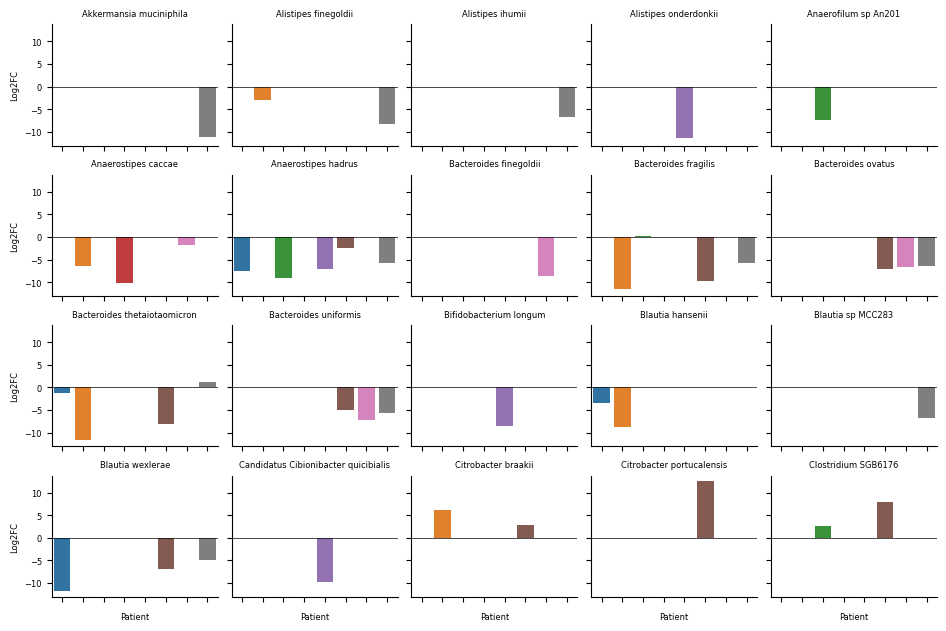

/tmp/ipykernel_11831/2167951613.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='Patient', y='Log2FC', col='Species',


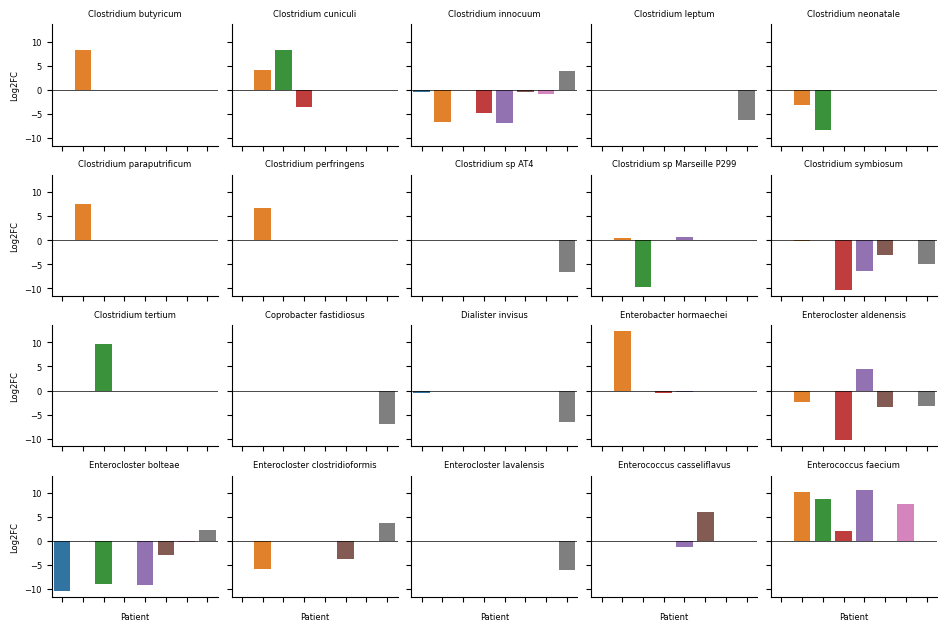

/tmp/ipykernel_11831/2167951613.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='Patient', y='Log2FC', col='Species',


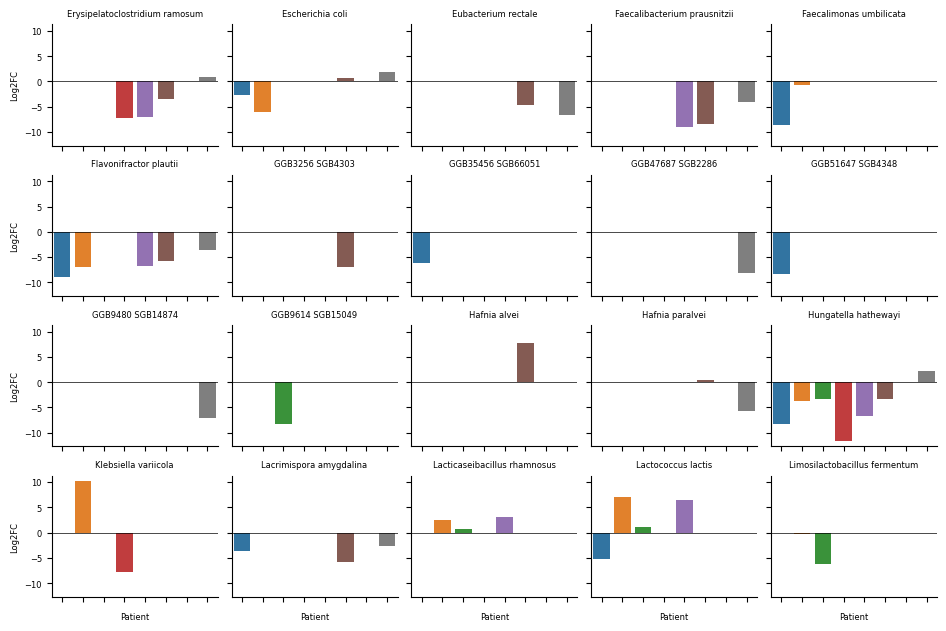

/tmp/ipykernel_11831/2167951613.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='Patient', y='Log2FC', col='Species',


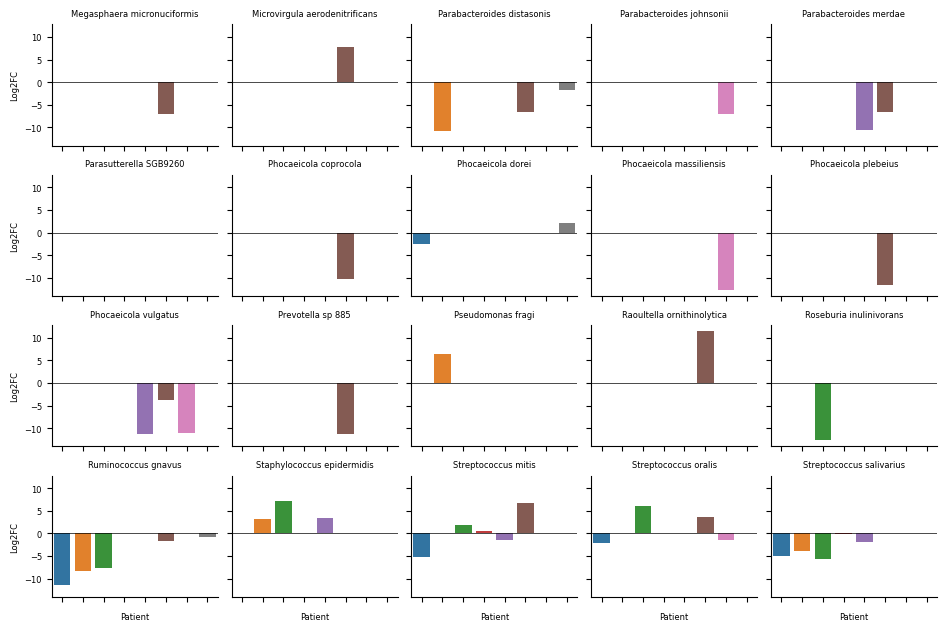

/tmp/ipykernel_11831/2167951613.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='Patient', y='Log2FC', col='Species',


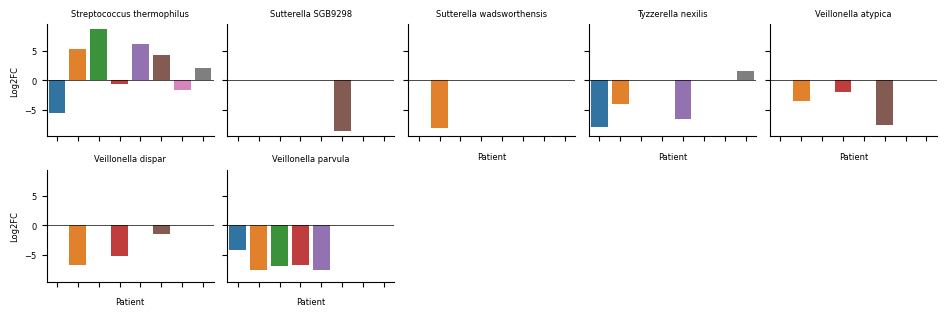

In [38]:
# Combined log2fc plot for all patients
# Prepare data for combined log2fc plot
combined_log2fc_data = []

for patient in patients_with_both:
    pre_sample = patient_samples[patient]['pre'][0] if patient_samples[patient]['pre'] else None
    post_sample = patient_samples[patient]['post'][0] if patient_samples[patient]['post'] else None
    
    if pre_sample and post_sample and pre_sample in species_data.columns and post_sample in species_data.columns:
        for species in all_species:
            # Find the species in the data
            species_rows = species_data[species_data['tax_name'] == species]
            if not species_rows.empty:
                idx = species_rows.index[0]
                pre_val = species_data.loc[idx, pre_sample]
                post_val = species_data.loc[idx, post_sample]
                fc = np.log2((post_val + 0.01) / (pre_val + 0.01))
                
                combined_log2fc_data.append({
                    'Species': species,
                    'Patient': patient,
                    'Log2FC': fc
                })

log2fc_df = pd.DataFrame(combined_log2fc_data)

# Create faceted log2fc plot - one facet per species
for i in range(0, len(all_species), 20):  # Process in batches of 20 species
    species_batch = all_species[i:i+20]
    batch_df = log2fc_df[log2fc_df['Species'].isin(species_batch)]
    
    g = sns.catplot(x='Patient', y='Log2FC', col='Species',
                   data=batch_df, kind='bar', col_wrap=5, height=mm_to_inches(40), aspect=1.2,
                   palette='tab10', legend=False,
                   sharey=True)
    
    # Add reference line at y=0 to each facet
    for ax in g.axes.flatten():
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    g.set_xticklabels(rotation=45, ha='right')
    g.set_titles("{col_name}")
    g.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'species_log2fc_facet_batch_{i//20 + 1}.png'), dpi=300)
    plt.show()


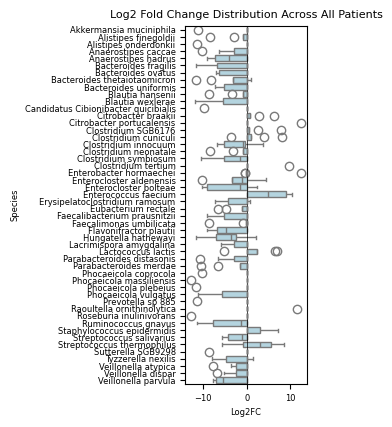

In [52]:
# Create one comprehensive boxplot with all species
# First, aggregate the data across patients to get mean values
species_summary = log2fc_df.groupby('Species')['Log2FC'].agg(['mean', 'std']).reset_index()
species_summary = species_summary.sort_values('mean', key=abs, ascending=False)

# Take top 50 species with highest absolute mean log2FC
top_species = species_summary.head(50)['Species'].tolist()
species_plot_data = log2fc_df[log2fc_df['Species'].isin(top_species)]

# Create a large comprehensive plot
plt.figure(figsize=(MAX_WIDTH_INCHES * 1, MAX_HEIGHT_INCHES * 0.9))
sns.boxplot(x='Log2FC', y='Species', data=species_plot_data, orient='h', color='lightblue')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.title('Log2 Fold Change Distribution Across All Patients')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'comprehensive_log2fc_boxplot.png'), dpi=300)
plt.show()

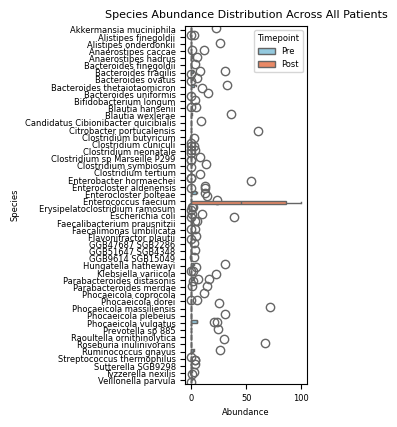

In [54]:
# Also create a full-species abundance plot for all species combined
species_abundance_summary = combined_df.groupby(['Species', 'Timepoint'])['Abundance'].mean().reset_index()
species_abundance_summary = species_abundance_summary.pivot(index='Species', columns='Timepoint', values='Abundance')
species_abundance_summary['Total'] = species_abundance_summary['Pre'] + species_abundance_summary['Post']
species_abundance_summary = species_abundance_summary.sort_values('Total', ascending=False)

# Take top 50 species by total abundance
top_abundant_species = species_abundance_summary.head(50).index.tolist()
abundance_plot_data = combined_df[combined_df['Species'].isin(top_abundant_species)]

# Create separate plots for Pre and Post
plt.figure(figsize=(MAX_WIDTH_INCHES * 1, MAX_HEIGHT_INCHES * 0.9))
sns.boxplot(x='Abundance', y='Species', hue='Timepoint', data=abundance_plot_data, 
           palette={'Pre': 'skyblue', 'Post': 'coral'}, orient='h')
plt.title('Species Abundance Distribution Across All Patients')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'comprehensive_abundance_boxplot.png'), dpi=300)
plt.show()

In [55]:
# Create a summary table with all the abundance and log2fc data
summary_data = pd.pivot_table(
    combined_df, 
    values='Abundance', 
    index=['Species'], 
    columns=['Patient', 'Timepoint']
)

# Add log2fc to the table
for patient in patients_with_both:
    patient_data = log2fc_df[log2fc_df['Patient'] == patient]
    for _, row in patient_data.iterrows():
        species = row['Species']
        fc = row['Log2FC']
        try:
            summary_data.loc[species, (patient, 'Log2FC')] = fc
        except:
            # If this combination doesn't exist in the pivot table
            pass

# Save to CSV
summary_data.to_csv(os.path.join(plots_dir, 'species_abundance_summary.csv'))